# Логистическая регрессия

# 1. Данные - посмотрим на них

In [ ]:
%%time
import numpy as np
import pandas as pd

df = pd.read_csv('application_train.csv')

CPU times: user 5.76 s, sys: 738 ms, total: 6.5 s
Wall time: 6.61 s


Датасет довольно большой и наши методы могут долго работать, поэтому мы возьмем случайной подмножество например в размере 50 000 и будем работать с ним.

In [ ]:
df = df.sample(n=50000, random_state=0).reset_index(drop=True)

In [ ]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,149741,1,Cash loans,F,N,N,0,117000.0,417024.0,20191.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
1,363290,0,Cash loans,M,N,Y,0,450000.0,640080.0,31261.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,436006,0,Revolving loans,M,Y,Y,0,450000.0,900000.0,45000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,0.0
3,377703,0,Cash loans,M,Y,N,1,360000.0,1125000.0,33025.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,188624,0,Cash loans,M,Y,Y,0,675000.0,835380.0,42840.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [ ]:
# Сразу удалим уникальный айди
df.drop(columns=['SK_ID_CURR'], inplace=True)

Видим, что у нас есть очень разнородные признаки 122 признака - среди них мы видим как числовые, так и бинарные, также видим категорилаьные, где классов больше, чем 2.

Давайте посмотрим на категориальные фичи, убедимся, что среди них нет тех, с которыми мы умеем работать и оставим только числовые и бинарные.

In [ ]:
%%time
for c in df.dtypes[df.dtypes == object].keys():
    print ("---- %s ---" % c)
    print (df[c].value_counts())

---- NAME_CONTRACT_TYPE ---
NAME_CONTRACT_TYPE
Cash loans         45188
Revolving loans     4812
Name: count, dtype: int64
---- CODE_GENDER ---
CODE_GENDER
F      33029
M      16970
XNA        1
Name: count, dtype: int64
---- FLAG_OWN_CAR ---
FLAG_OWN_CAR
N    32981
Y    17019
Name: count, dtype: int64
---- FLAG_OWN_REALTY ---
FLAG_OWN_REALTY
Y    34758
N    15242
Name: count, dtype: int64
---- NAME_TYPE_SUITE ---
NAME_TYPE_SUITE
Unaccompanied      40492
Family              6490
Spouse, partner     1838
Children             523
Other_B              260
Other_A              154
Group of people       41
Name: count, dtype: int64
---- NAME_INCOME_TYPE ---
NAME_INCOME_TYPE
Working                 25905
Commercial associate    11653
Pensioner                8910
State servant            3520
Student                     6
Unemployed                  4
Maternity leave             2
Name: count, dtype: int64
---- NAME_EDUCATION_TYPE ---
NAME_EDUCATION_TYPE
Secondary / secondary special    3539

Мы видим некоторые интересные колонки например
'NAME_CONTRACT_TYPE'
'CODE_GENDER'
'FLAG_OWN_CAR'
'FLAG_OWN_REALTY'
'EMERGENCYSTATE_MODE'

Мы видим, что это все на самом деле бинарные признаки, но либо есть пропуски либо имеют текстовые названия.



## 1.1. Перейдем к простейшей обработке, которая нам дальше очень поможет

Также мы видим, что в признаке пол - есть пропущенные значения необычного вида - XNA, дачайте заменим их на обычные пропуски.

In [ ]:
df.replace('XNA', np.nan, inplace=True)

In [ ]:
#это все колонки, которые имеют количественные значения или числовые (например бинарные 0,1)
numeric_features = df.dtypes[(df.dtypes == np.float64) | (df.dtypes == np.int64)].keys().tolist()
#также выберем заинетерсовавшие нас категориальные признаки
cat_features = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY','EMERGENCYSTATE_MODE']

Ограничимся набором таких колонок, остальные пока отложим.

In [ ]:
df = df[numeric_features + cat_features]

Отлично теперь можно переходить к обработке пропущенных значений.

## 1.2. Сформируем отложенную выборку

In [ ]:
#Отложим часть выборки, чтобы убедиться в дальнейшем, что наша модель не переобучилась.
df_test = df.sample(n=10000, random_state=0)
df_train = df.drop(index=df_test.index)

df_test = df_test.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

Теперь мы можем начать заполнять пропущенные значения и обрабатывать признаки.

## 1.3. Обработка категориальных признаков

### 1.3.1. Обработка пропущенных значений

Начнем с обработки пропущенных значений, как мы помним есть несколько вариантов, мы выберем **заполнение средним** и **заполнение самым частым значением**

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
# Создадим класс обработчика пропущенных значений
# Будем заполнять самым частым значением
imp_cat = SimpleImputer(strategy="most_frequent")

In [ ]:
%%time
df_train[cat_features] = imp_cat.fit_transform(df_train[cat_features])
df_test[cat_features] = imp_cat.transform(df_test[cat_features])

CPU times: user 47.7 ms, sys: 798 µs, total: 48.5 ms
Wall time: 49.6 ms


In [ ]:
df_train[cat_features].head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,EMERGENCYSTATE_MODE
0,Cash loans,F,N,N,No
1,Revolving loans,M,Y,Y,No
2,Cash loans,M,Y,Y,No
3,Cash loans,M,Y,Y,No
4,Cash loans,F,N,Y,No


<!-- ### 1.3.1. Перевод в числовое значение (encoding) -->

Теперь нам нужно перевести их в числовой тип. То есть одному типу присвоить значение 1 - другому 0.

###  1.3.2. Перевод в числовое значение (encoding)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
# Создадим класс категориального обработчика
enc = OrdinalEncoder()

In [ ]:
# Всем категориальным значениям присвоим либо 1 либо 0, в зависимости от того, какое значение они принимают.
df_train[cat_features] = enc.fit_transform(df_train[cat_features])
df_test[cat_features] = enc.transform(df_test[cat_features])

In [ ]:
df_train[cat_features].head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,EMERGENCYSTATE_MODE
0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0
2,0.0,1.0,1.0,1.0,0.0
3,0.0,1.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0


Отлично категориальные фичи мы обработали, теперь перейдем к числовым.

## 1.4. Обработка числовых признаков

### 1.4.1 Обработка пропущенных значений

#### 1.4.1.1. У числовых фичей только с двумя значениями

В числовых фичах можно заметить, что есть такие признаки как флаги  - они по другому являются бинарными, то есть принимают значение либо 0 либо 1. Значит при обработке их пропущенных значений нужно будет использовать стратегию заполнения самым частым значением. Для всех остальных признаков бедум использовать заполнение средним значением. Повторим то что делали для категориальных признаков здесь.

In [ ]:
df[numeric_features].head()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,0,117000.0,417024.0,20191.5,360000.0,0.020246,-21774,-2125,-4611.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
1,0,0,450000.0,640080.0,31261.5,450000.0,0.046220,-18499,-2055,-3052.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,0,450000.0,900000.0,45000.0,900000.0,0.010643,-18084,-4159,-8525.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,0.0
3,0,1,360000.0,1125000.0,33025.5,1125000.0,0.018634,-12319,-2532,-12304.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,675000.0,835380.0,42840.0,675000.0,0.020713,-10151,-2516,-2789.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


Для начала найдем все такие признаки, которые принимают только два значения и запомним их, чтобы обработать отдельно.

In [ ]:
cat_bin_features = []
for i in numeric_features:
    if len(df[i].value_counts().keys().tolist()) == 2:
        cat_bin_features.append(i)

Давайте посмотрим на них.

In [ ]:
cat_bin_features

['TARGET',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

Мы уже так обрабатывали другие категориальные признаки, поэтому здесь просто повторим.

In [ ]:
# Создадим класс обработчика пропущенных значений
# Будем заполнять самым частым значением
imp_bin_cat = SimpleImputer(strategy="most_frequent")

In [ ]:
%%time
df_train[cat_bin_features] = imp_cat.fit_transform(df_train[cat_bin_features])
df_test[cat_bin_features] = imp_cat.transform(df_test[cat_bin_features])

CPU times: user 83.3 ms, sys: 82 µs, total: 83.3 ms
Wall time: 82.6 ms


#### 1.4.1.2. У всех остальных числовых фичей

In [ ]:
# Создадим класс обработчика пропущенных значений
# Будем заполнять медианным
imp_numeric = SimpleImputer(missing_values=np.nan, strategy='mean')

In [ ]:
%%time
df_train[numeric_features] = imp_cat.fit_transform(df_train[numeric_features])
df_test[numeric_features] = imp_cat.transform(df_test[numeric_features])

CPU times: user 445 ms, sys: 21.4 ms, total: 467 ms
Wall time: 474 ms


Отлично, мы обработали данные.
Заполнили все пропуски. Перевели категориальные фичи в удобный для нас вид. Собрали итоговый обучающий датасет и итоговый тестовый датасет.

Теперь разделить пространство объектов от пространсва ответов в обучающей и тестовой выборках

In [ ]:
#здесь можно посмотреть какие колоки будут у первых 10 признаков

In [ ]:
X_train = df_train.drop(columns='TARGET')
X_test = df_test.drop(columns='TARGET')

y_train = df_train['TARGET']
y_test = df_test['TARGET']

## 1.5. Скалирование данных

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

Используем стандартное преобразование данных как в прошлом уроке.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# зададим объекты - трансформеры,
# которые преобразуют наши данные и запомнят средние

standard = StandardScaler()

# метод фит вычисляет все вспомогательные значения по каждому признаку
standard.fit(X_train)

#нам нужно преобразовать как тестовую, так и тренировочную выборку,
#хорошим тоном считается вычислять вспомогательные значения по обучающей выборке
X_train_standard = standard.transform(X_train)
X_test_standard = standard.transform(X_test)

Теперь можно переходить к части моделирования.

# 2. Моделирование

## 2.1 Посмотрим на метрику

In [ ]:
from sklearn.metrics import roc_auc_score

## 2.2 Построим наивный алгоритм и посмотрим какое качество он дает

In [ ]:
roc_auc_score(y_train, [0]*len(y_train))

0.5

In [ ]:
roc_auc_score(y_train, [1]*len(y_train))

0.5

Мы видим, что не удалось обмануть ROC-AUC  - он правильно понял, что наша модель плохая. Качество 0.5 говорит о том, что наша модель не лучше чем "подбрасывать монетку".

## 2.3 Построим логистическую регрессию

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
#Нужно ответить на вопрос - посмотрев докуметацию
#Какая регуляризация используется здесь в дефолтных параметрах
#L1, L2 или никакой
logreg = LogisticRegression(max_iter=1000)

In [ ]:
X_train = df_train[df_train.columns[1:][:10]]
X_test = df_test[df_train.columns[1:][:10]]
y_train = df_train['TARGET']
y_test = df_test['TARGET']


In [ ]:
standard = StandardScaler()
standard.fit(X_train)
X_train_standard = standard.transform(X_train)
X_test_standard = standard.transform(X_test)

In [ ]:
#Обучим логистическую регрессию
logreg.fit(X_train_standard, y_train)

LogisticRegression(max_iter=1000)

## 2.4 Замерим качество

In [ ]:
#Чтобы вернуть предсказание вероятностей принадлежности,
#нужно использовать метод predict_proba он возвращает
#в первой колонке вероятность принадлежности к классу 0, а во второй к классу 1.
proba = logreg.predict_proba(X_test_standard)

In [ ]:
roc_auc = roc_auc_score(y_test, proba[:,1])

In [ ]:
roc_auc

0.6294881588999236

## 2.5 Построим ROC

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_standard)[:,1])

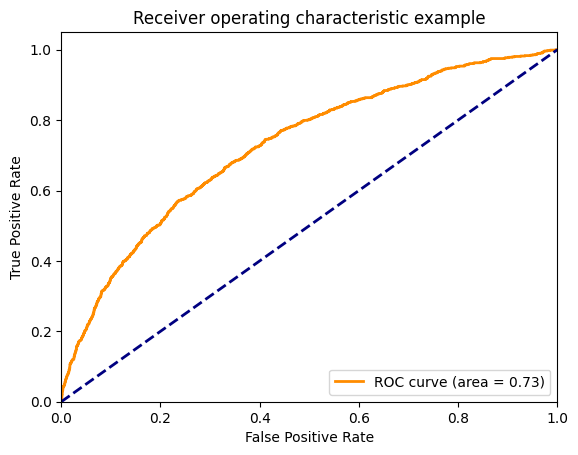

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# 2.6. Выберем порог и замерим precision, recall, f-score

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [ ]:
print(f" Полнота при предсказании 1: {recall_score(y_test, [1]*len(y_test))} \n \
Точность при предсказании 1: {precision_score(y_test, [1]*len(y_test))} \n \
F-мера при предсказании 1: {f1_score(y_test, [1]*len(y_test))}")

 Полнота при предсказании 1: 1.0 
 Точность при предсказании 1: 0.0837 
 F-мера при предсказании 1: 0.15447079450032297


In [ ]:
print(f" Полнота при предсказании 0: {recall_score(y_test, [0]*len(y_test))} \n \
Точность при предсказании 0: {precision_score(y_test, [0]*len(y_test))} \n \
F-мера при предсказании 0: {f1_score(y_test, [0]*len(y_test))}")

 Полнота при предсказании 0: 0.0 
 Точность при предсказании 0: 0.0 
 F-мера при предсказании 0: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
predictions = proba[:, 1].copy()
predictions[np.where(predictions > 0.1)] = 1
predictions[np.where(predictions <= 0.1)] = 0

In [ ]:
print(f" Полнота при предсказании с порогом 0.1: {recall_score(y_test, predictions)} \n \
Точность при предсказании с порогом 0.1: {precision_score(y_test, predictions)} \n \
F-мера при предсказании с порогом 0.1: {f1_score(y_test, predictions)}")

 Полнота при предсказании с порогом 0.1: 0.5412186379928315 
 Точность при предсказании с порогом 0.1: 0.18437118437118438 
 F-мера при предсказании с порогом 0.1: 0.2750455373406193
